In [46]:
import pymodels as pm
import pyaccel as pa
import numpy as np
import matplotlib.pyplot as plt
from auxiliar_scripts.nlk import si_nlk_kick
from mathphys.beam_optics import beam_rigidity

In [47]:
plt.style.use(['notebook'])

In [48]:
fig_path = r'/home/jucelio/notebooks/figures/TS_effects_on_exchange/'

# Useful functions

In [49]:
def compute_emittances(bunch, local_twiss):
    """."""
    twiss = local_twiss
    etax, etapx = twiss.etax, twiss.etapx
    etay, etapy = twiss.etay, twiss.etapy
    disp = np.array([[etax], [etapx], [etay], [etapy], [0], [0]])
    bunch_nodisp = bunch - bunch[4]*disp
    emitx = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[0:2, :])))
    emity = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[2:4, :])))
    
    return emitx, emity

In [50]:
def plot_phases_diagrams(bunch, bunch_ex, emitx, emity, emitx_ex, emity_ex, title=""):
    fig, ax = plt.subplots(1,2, figsize = (10,6), sharex=False, sharey=False)
    x, x_ = bunch[0, :]*1e3, bunch[1, :]*1e3
    y, y_ = bunch[2, :]*1e3, bunch[3, :]*1e3
    x_ex, x__ex = bunch_ex[0, :]*1e3, bunch_ex[1, :]*1e3
    y_ex, y__ex = bunch_ex[2, :]*1e3, bunch_ex[3, :]*1e3

    ax[0].scatter(x, x_, s=2, label=r'$\epsilon_x = {:.3f} nm$'.format(emitx*1e9), alpha=1, color='tab:blue')
    ax[0].scatter(x_ex, x__ex, s=2, label=r'$\epsilon_x (exchanged) = {:.3f} nm$'.format(emitx_ex*1e9), 
                  color='tab:red', alpha=1)

    ax[1].scatter(y_ex, y__ex, s=2, label=r'$\epsilon_y (exchanged) = {:.3f} nm$'.format(emity_ex*1e9),
                  color='tab:red', alpha=1)
    ax[1].scatter(y, y_, s=2, label=r'$\epsilon_y = {:.2f} nm$'.format(emity*1e9), alpha=1, color='tab:blue')


    fig.suptitle(title, fontsize=16)
    ax[0].set_xlabel('x [mm]')
    ax[0].set_ylabel("x' [mrad]")
    ax[1].set_xlabel('y [mm]')
    ax[1].set_ylabel("y' [mrad]")
    ax[0].legend(loc='upper left')
    ax[1].legend(loc='upper left')
#     plt.tight_layout()
#     plt.savefig(fname,dpi=160)
    return fig, ax
    #     plt.show()

# Bunch at Booster end - TS beginning

In [51]:
# Creating a booster with small coupling
bo = pm.bo.create_accelerator(energy=3e9)
bo_famdata = pm.bo.get_family_data(bo)
bo.radiation_on = True
bo.vchamber_on = True
bo.cavity_on = True
KsL = -0.015
qs_idx = bo_famdata['QS']['index']
bo[qs_idx[0][0]].KsL = KsL

# Creating the TS line
ts, ts_init_twiss = pm.ts.create_accelerator(
                    optics_mode="M2")  # Maybe is better change to "M2"
ts.radiation_on = True
ts.vchamber_on = True

Creating the bunch

In [52]:
bo_eqparam = pa.optics.EqParamsFromBeamEnvelope(accelerator=bo)
emit1 = bo_eqparam.emit1
emit2 = bo_eqparam.emit2
sigme = bo_eqparam.espread0
sigmal = bo_eqparam.bunlen
n_part = 5000

# Supposing a emittance exchange with R=0.95
R = 0.95
deltaemit = emit1-emit2
emit1_ex = emit1 - deltaemit*R
emit2_ex = emit2 + deltaemit*R

bunch = pa.tracking.generate_bunch(n_part=n_part, emit1=emit1, emit2=emit2, 
                                   sigmae=sigme, sigmas=sigmal, optics=ts_init_twiss)
bunch_ex = pa.tracking.generate_bunch(n_part=n_part, emit1=emit1_ex, emit2=emit2_ex, 
                                   sigmae=sigme, sigmas=sigmal, optics=ts_init_twiss)

Computing emittances

In [53]:
# Shifting the bunch to the TS orbit
# centroid_at_ts =  np.array([2.73724778e-03,  4.25220469e-04, -7.24359070e-21,  3.19401356e-21,
#  -7.96083635e-05, -8.05961219e-02])
centroid_at_ts = np.array([0,0,0,0,0,0])
bunch = bunch + centroid_at_ts[:, None]
bunch_ex = bunch_ex + centroid_at_ts[:, None]

emitx, emity = compute_emittances(bunch, ts_init_twiss)
emitx_ex, emity_ex = compute_emittances(bunch_ex, ts_init_twiss)

Phase diagram

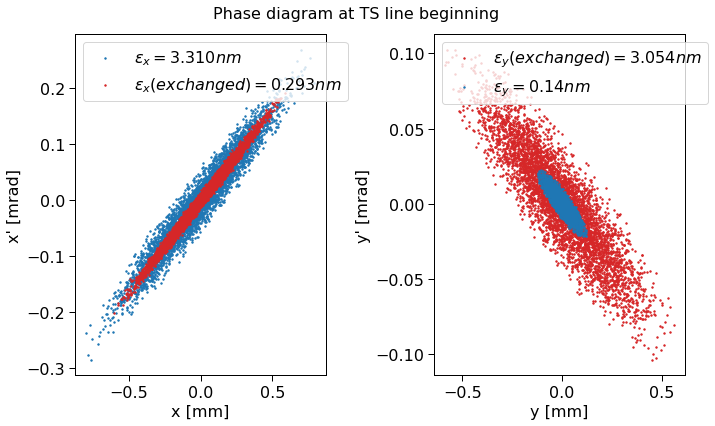

In [54]:
fname =  fname=fig_path+"before_ts.jpg"

fig, ax = plot_phases_diagrams(
    bunch, bunch_ex, emitx, emity,
    emitx_ex, emity_ex, title='Phase diagram at TS line beginning')
plt.tight_layout()
plt.savefig(fname,dpi=160)
plt.show()

Beam in horizontal and vertical coordinates

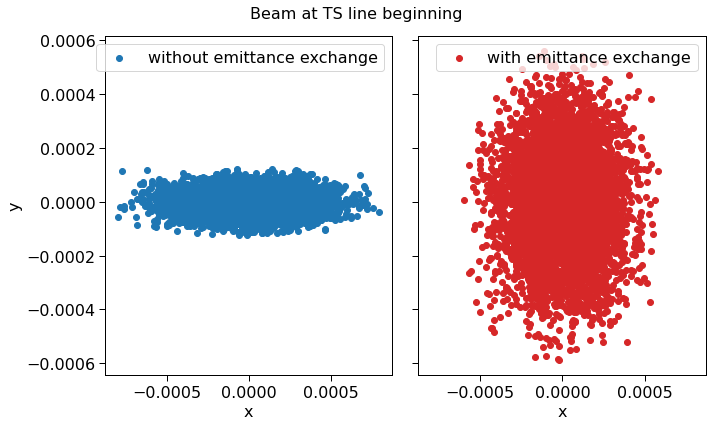

In [55]:
x, y = bunch[0, :], bunch[2, :]
x_ex, y_ex = bunch_ex[0, :], bunch_ex[2, :]

fig, ax = plt.subplots(1,2, figsize = (10,6), sharex=True, sharey=True)
fig.suptitle('Beam at TS line beginning', fontsize=16)

ax[0].scatter(x,y, label = 'without emittance exchange')
ax[1].scatter(x_ex, y_ex, color='tab:red', label='with emittance exchange')

ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('x')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig("beam_size_before.jpg", dpi=160)

# TS Tracking

In [56]:
# Passing through TS
part_out, lost_flag, *_ = pa.tracking.line_pass(
            ts, bunch, indices='closed'
            )
part_out_ex, lost_flag_ex, *_ = pa.tracking.line_pass(
            ts, bunch_ex, indices='closed'
            )

In [57]:
bunch_end = part_out[:, :, -1]
bunch_ex_end = part_out_ex[:, :, -1]

Computing emittances at the end of TS line

In [58]:
twi, *_ = pa.optics.calc_twiss(accelerator=ts, init_twiss=ts_init_twiss)
twiss = twi[-1]
# Without emittance exchange
emitx, emity =compute_emittances(bunch_end, twiss)
# With emittance exchange
emit1_ex, emit2_ex = compute_emittances(bunch_ex_end, twiss)

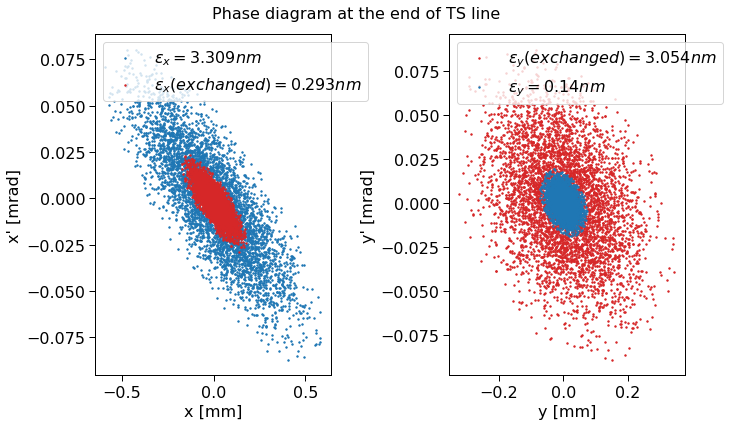

In [59]:
fname = fig_path + "before_ts.jpg"
plot_phases_diagrams(bunch_end, bunch_ex_end, emitx, emity,
                    emitx_ex, emity_ex, title='Phase diagram at the end of TS line')
plt.tight_layout()
plt.savefig(fname,dpi=160)
plt.show()

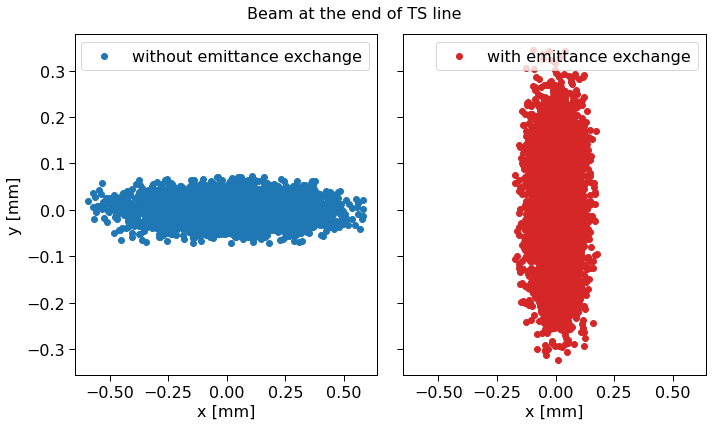

In [60]:
x, y = bunch_end[0, :], bunch_end[2, :]
x_ex, y_ex = bunch_ex_end[0, :], bunch_ex_end[2, :]

fig, ax = plt.subplots(1,2, figsize = (10,6), sharex=True, sharey=True)
fig.suptitle('Beam at the end of TS line ', fontsize=16)

ax[0].scatter(x*1e3, y*1e3, label = 'without emittance exchange')
ax[1].scatter(x_ex*1e3, y_ex*1e3, color='tab:red', label='with emittance exchange')
ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')
ax[1].set_xlabel('x [mm]')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig("beam_after.jpg", dpi=160)

# NLK effect on the exchanged beam

## Transporting the beam until nlk

Creating Sirius, getting family data and changing the bunch reference frame

In [61]:
si = pm.si.create_accelerator()
si.cavity_on = True
si.radiation_on = True
si.vchamber_on = True

twi, _ = pa.optics.calc_twiss(si)
famdata = pm.si.get_family_data(si)
nlk_idx = famdata['InjNLKckr']['index']
sept_idx = pa.lattice.find_indices(
            lattice=si, attribute_name='fam_name', value='InjSeptF')
offset = np.array([-17.35e-3, 2.4e-3, 0, 0, 0, 0])[:, None]

bunch_sept = bunch_end - bunch_end.mean(axis=1)[:, None] + offset
bunchex_sept = bunch_ex_end - bunch_end.mean(axis=1)[:, None] +  offset

Tracking from Septa to NLK 

In [62]:
bunch_nlk, *_ = pa.tracking.line_pass(
    si, particles=bunch_sept, indices=nlk_idx[0], element_offset=sept_idx[0], parallel=True)

bunchex_nlk, *_ = pa.tracking.line_pass(
    si, particles=bunchex_sept, indices=nlk_idx[0], element_offset=sept_idx[0], parallel=True)

emitx, emity = compute_emittances(bunch_nlk, twi[nlk_idx[0][0]])
emitx_ex, emity_ex = compute_emittances(bunchex_nlk, twi[nlk_idx[0][0]])

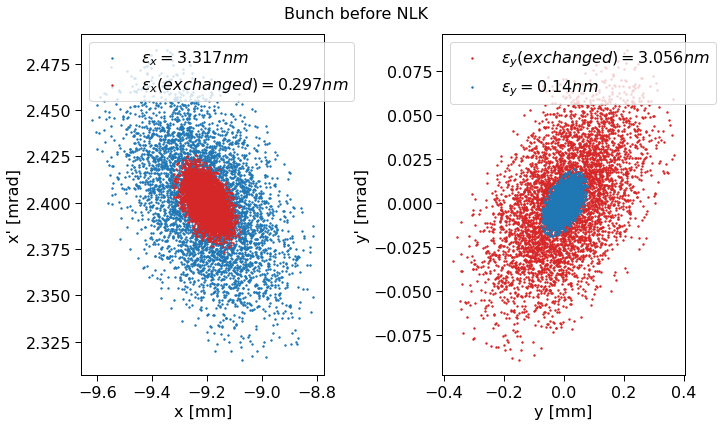

In [63]:
fig, ax = plot_phases_diagrams(
            bunch_nlk, bunchex_nlk, emitx, emity, 
            emitx_ex, emity_ex, title='Bunch before NLK')
plt.tight_layout()
plt.show()

## Kicking the beam

Loading the nlk profile

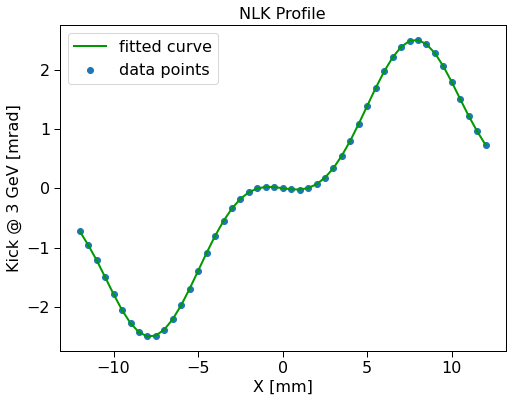

In [64]:
monomials=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x, integ_field, kickx, LPolyB = si_nlk_kick(plot_flag=True, strength=0.266, fit_monomials=monomials)
# plt.xticks(np.arange(-12,13))
# plt.tick_params(which='major', labelsize =10)
plt.show()

In [65]:
np.min(kickx)

-0.0025004133577500084

Setting the NLK pulse and shifting the Sirius beginning at NLK

In [66]:
nlk_l = si[nlk_idx[0][0]].length
si[nlk_idx[0][0]].polynom_b = LPolyB[0]/nlk_l
# si = pa.lattice.shift(si, nlk_idx[0][0])

Putting the bunch at injection NLK based on offset values available on Wiki-Sirius

In [67]:
# nlk_b_offset = np.array([-8e-3, 2.4e-3, 0, 0, 0, 0])[:, None] # Bunch offset at NLK
# bunch_si = bunch_end - bunch_end.mean(axis=1)[:, None]
# bunch_si += nlk_b_offset

Bunch after NLK

In [68]:
# part_out, *_ = pa.tracking.ringpass(si, bunch_si, parallel=True)

nlk_si = si[nlk_idx[0][0]:nlk_idx[0][0]+1]

part_out, *_ = pa.tracking.line_pass(nlk_si, bunch_nlk, indices='closed', parallel=True)

part_out_ex, *_ = pa.tracking.line_pass(nlk_si, bunchex_nlk, indices='closed', parallel=True)

bunch_final = part_out[:,:,-1]
bunchex_final = part_out_ex[:,:,-1]

# Emittances after NLK
si_twi, _ = pa.optics.calc_twiss(si)
emitx, emity = compute_emittances(bunch_final, si_twi[0])
emitx_ex, emity_ex = compute_emittances(bunchex_final, si_twi[0])

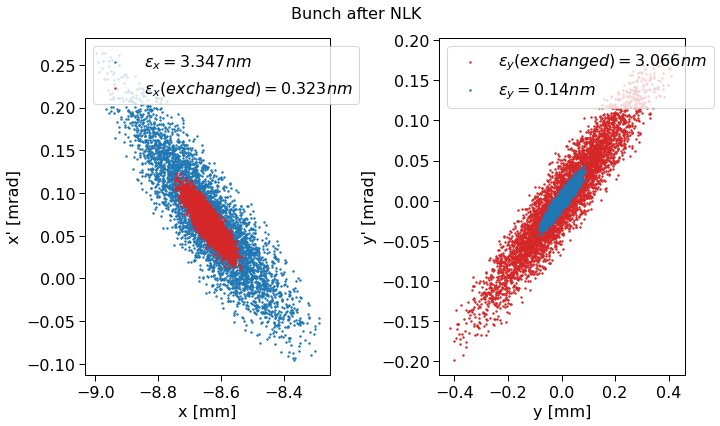

In [69]:
fig, ax = plot_phases_diagrams(
            bunch_final, bunchex_final, emitx, emity, 
            emitx_ex, emity_ex, title='Bunch after NLK')
plt.tight_layout()
plt.show()

In [70]:
np.mean(bunch_final, axis=1)

array([-8.63954126e-03,  7.01005968e-05, -2.51652071e-09, -9.93978766e-09,
       -4.59003425e-09,  1.02334560e-05])

Disable NLK

In [71]:
si[nlk_idx[0][0]].polynom_b = np.zeros([7])

Computing dynamical aperture

In [72]:
particle = np.array([8e-3, 0, 0.3e-3, 0, 0, 0])[:, None]
# part_out, *_ = pa.tracking.ring_pass(
#     si, particle, parallel=True, nr_turns = 2000, element_offset=nlk_idx[0][0], 
#     turn_by_turn=True)

part_out, *_ = pa.tracking.ring_pass(
    si, particle, parallel=True, nr_turns = 2000, 
    turn_by_turn=True)

In [73]:
apert = part_out

Plotting bunch with dynamical aperture

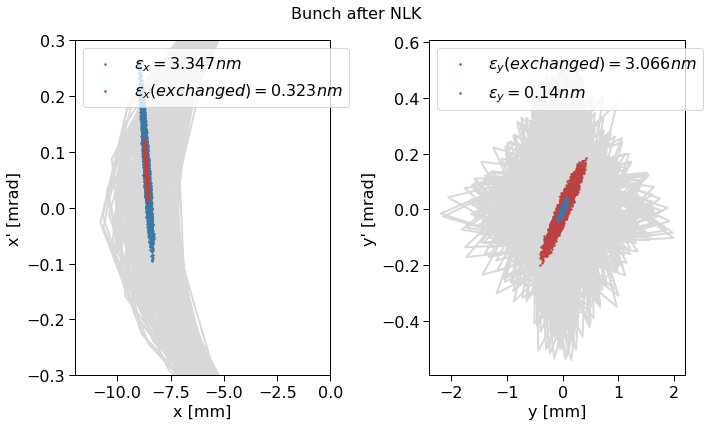

In [74]:
fig, ax = plot_phases_diagrams(
            bunch_final, bunchex_final, emitx, emity, 
            emitx_ex, emity_ex, title='Bunch after NLK')
ax[0].plot(apert[0]*1e3, apert[1]*1e3, alpha=0.3, c='tab:gray')
ax[1].plot(apert[2]*1e3, apert[3]*1e3, alpha=0.3, c='tab:gray')

ax[0].set_xlim([-12, 0])
ax[0].set_ylim([-0.3, 0.3])
plt.tight_layout()
plt.show()

## Testing different initial offsets at NLK beginning

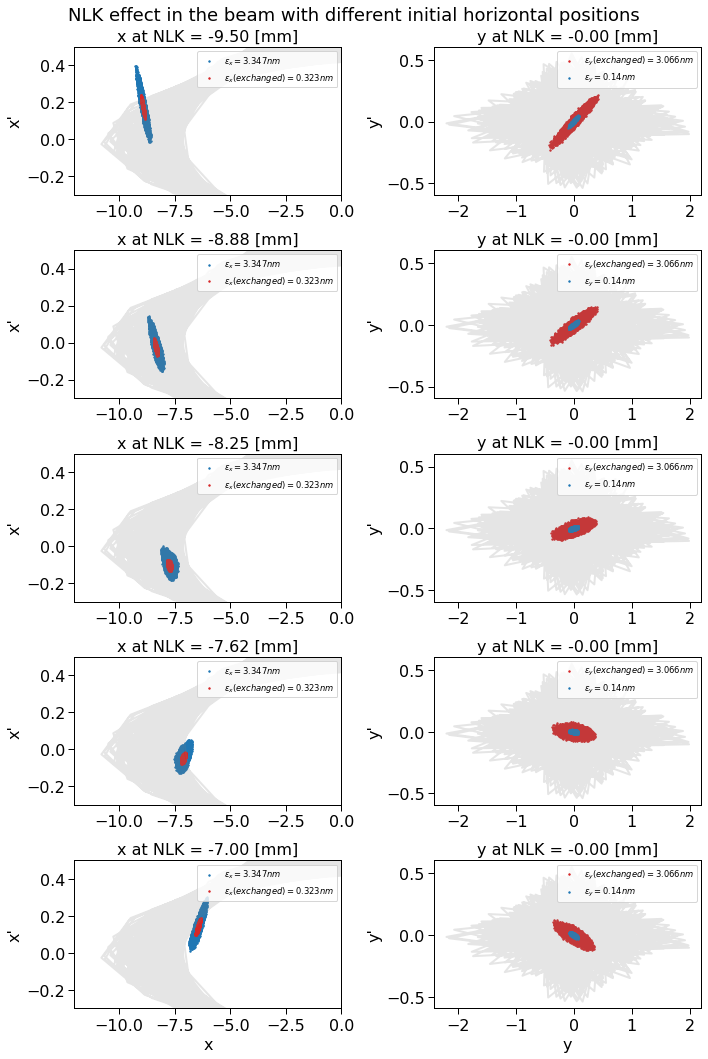

In [81]:
x_list = np.linspace(-9.5,-7.0,num=5)*1e-3
bunch = bunch_nlk
bunchex = bunchex_nlk

fig, ax = plt.subplots(x_list.size, 2, figsize=(10,15))

for i, x_0 in enumerate(x_list):
    bunch[0, :] = bunch_nlk[0, :] - bunch_nlk[0, :].mean() + x_0
    bunchex[0, :] = bunchex_nlk[0, :] - bunchex_nlk[0, :].mean() + x_0
    y_0 = bunch[2].mean()
    
    # Setting NLK
    nlk_l = si[nlk_idx[0][0]].length
    si[nlk_idx[0][0]].polynom_b = LPolyB[0]/nlk_l
    
    # Tracking beam through NLK
    nlk_si = si[nlk_idx[0][0]:nlk_idx[0][0]+1]
    part_out, *_ = pa.tracking.line_pass(nlk_si, 
                                         bunch_nlk, indices='closed',
                                         parallel=True)
    part_out_ex, *_ = pa.tracking.line_pass(nlk_si,
                                            bunchex_nlk, indices='closed',
                                            parallel=True)
    bunch_final = part_out[:,:,-1]
    bunchex_final = part_out_ex[:,:,-1]
    
    # Plotting the results
    ax[i][0].plot(apert[0]*1e3, apert[1]*1e3, alpha=0.2, c='tab:gray')
    ax[i][0].set_xlim([-12, 0])
    ax[i][0].set_ylim([-0.3, 0.5])
    ax[i][1].plot(apert[2]*1e3, apert[3]*1e3, alpha=0.2, c='tab:gray')
    
    x, x_ = bunch_final[0, :]*1e3, bunch_final[1, :]*1e3
    y, y_ = bunch_final[2, :]*1e3, bunch_final[3, :]*1e3
    x_ex, x__ex = bunchex_final[0, :]*1e3, bunchex_final[1, :]*1e3
    y_ex, y__ex = bunchex_final[2, :]*1e3, bunchex_final[3, :]*1e3

    ax[i][0].scatter(x, x_, s=2, label=r'$\epsilon_x = {:.3f} nm$'.format(emitx*1e9), alpha=1, color='tab:blue')
    ax[i][0].scatter(x_ex, x__ex, s=2, label=r'$\epsilon_x (exchanged) = {:.3f} nm$'.format(emitx_ex*1e9), 
                  color='tab:red', alpha=1)
    ax[i][1].scatter(y_ex, y__ex, s=2, label=r'$\epsilon_y (exchanged) = {:.3f} nm$'.format(emity_ex*1e9),
                  color='tab:red', alpha=1)
    ax[i][1].scatter(y, y_, s=2, label=r'$\epsilon_y = {:.2f} nm$'.format(emity*1e9), alpha=1, color='tab:blue')
    ax[i][0].legend(loc='upper right', fontsize='small')
    ax[i][1].legend(loc='upper right', fontsize='small')
    ax[i][0].set_title(f'x at NLK = {x_0*1e3:.2f} [mm]')
    ax[i][1].set_title(f'y at NLK = {y_0*1e3:.2f} [mm]')
    ax[i][0].set_ylabel("x'")
    ax[i][1].set_ylabel("y'")

ax[i][0].set_xlabel('x')
ax[i][1].set_xlabel('y')
fig.suptitle("NLK effect in the beam with different initial horizontal positions", fontsize=18)
plt.tight_layout(pad=1.3)
plt.savefig('figures/TS_effects_on_exchange/NLK_effect.png', dpi=300)